In [ ]:
# pip install torch==2.3.0 torchvision==0.18.0

In [1]:
#import torch
import pandas as pd
import numpy as np

from scipy.stats import mannwhitneyu, fisher_exact, stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

#from statsmodels.api import add_constant, OLS
#from statsmodels.gam.api import BSplines
#from statsmodels.gam.generalized_additive_model import GLMGam

import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost

c:\Users\pu.0580\Desktop\Projects\Projects\FGF14\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)
print(df.head())

  patient_id genetics_conclusion  allele_1  allele_2  gender  affect_sibl  \
0    FGF14+1                 FGF       9.0     482.0       1            0   
1    FGF14+2                 FGF      17.0     377.0       0            0   
2    FGF14+3                 FGF      16.0     324.0       0            0   
3    FGF14+4                 FGF      56.0     350.0       0            0   
4    FGF14+5                 FGF       9.0     353.0       0            1   

   affect_parent  start_episodic  start_gait_balance  start_diplopia  ...  \
0              1               1                   1               0  ...   
1              0               1                   0               1  ...   
2              0               1                   1               0  ...   
3              0               1                   1               0  ...   
4              0               0                   1               0  ...   

   dx_impaired_HIT  pyramidal_signs  dx_bradykinesia  dx_postural_instab  

In [3]:
column_names = pd.DataFrame(df.columns, columns = ['Names'])
print(column_names.to_string(index=False))

                         Names
                    patient_id
           genetics_conclusion
                      allele_1
                      allele_2
                        gender
                   affect_sibl
                 affect_parent
                start_episodic
            start_gait_balance
                start_diplopia
             start_oscillopsia
              start_dysarthria
                  start_tremor
            start_bradykinesia
                start_erectile
                 start_dyspnea
                 start_urinary
             age_clinical_diag
                 hot_cross_bun
             putaminal_atrophy
                 age_epi_sympt
                       UMSAR_I
                      UMSAR_II
         dx_downbeat_nystagmus
        dx_gait_balance_impair
                      dx_falls
                  dx_dysphagia
                    dx_vertigo
       dx_autonomic_dysfuntion
           dx_urinary_problems
               dx_constipation
    dx_o

In [4]:
counts = []

for column in df.columns:
    num_unique_values = df[column].nunique()
    counts.append([column, num_unique_values])

counts = pd.DataFrame(counts, columns=['Variable', 'Number_Unique'])
print(counts.to_string(index=False))

                      Variable  Number_Unique
                    patient_id             60
           genetics_conclusion              3
                      allele_1             17
                      allele_2             34
                        gender              2
                   affect_sibl              2
                 affect_parent              2
                start_episodic              2
            start_gait_balance              2
                start_diplopia              2
             start_oscillopsia              2
              start_dysarthria              2
                  start_tremor              2
            start_bradykinesia              2
                start_erectile              2
                 start_dyspnea              2
                 start_urinary              2
             age_clinical_diag             30
                 hot_cross_bun              2
             putaminal_atrophy              2
                 age_epi_sympt    

In [5]:
def categorize_var(number_unique):
    if number_unique <= 2:
        return "Binary"
    elif number_unique == 3:
        return "Group"
    else:
        return "Continuous"
    
counts['Variable_Type'] = counts['Number_Unique'].apply(categorize_var)
counts.at[0, 'Variable_Type'] = 'ID'
print(counts.to_string(index=False))

                      Variable  Number_Unique Variable_Type
                    patient_id             60            ID
           genetics_conclusion              3         Group
                      allele_1             17    Continuous
                      allele_2             34    Continuous
                        gender              2        Binary
                   affect_sibl              2        Binary
                 affect_parent              2        Binary
                start_episodic              2        Binary
            start_gait_balance              2        Binary
                start_diplopia              2        Binary
             start_oscillopsia              2        Binary
              start_dysarthria              2        Binary
                  start_tremor              2        Binary
            start_bradykinesia              2        Binary
                start_erectile              2        Binary
                 start_dyspnea          

In [6]:
continuous_vars = counts[counts['Variable_Type'] == 'Continuous']['Variable'].tolist()
binary_vars = counts[counts['Variable_Type'] == 'Binary']['Variable'].tolist()
print(df.shape, len(continuous_vars), len(binary_vars))  

(60, 71) 7 62


In [7]:
columns_to_subset = ['genetics_conclusion'] + continuous_vars
df_continuous = df[columns_to_subset].copy()
df_continuous[continuous_vars] = df_continuous[continuous_vars].apply(pd.to_numeric, errors='coerce')
df_continuous

,genetics_conclusion,allele_1,allele_2,age_clinical_diag,age_epi_sympt,UMSAR_I,UMSAR_II,SARA
0,FGF,9.0,482.0,70,70,NaN,NaN,NaN
1,FGF,17.0,377.0,50,48,NaN,NaN,5.0
2,FGF,16.0,324.0,68,66,NaN,NaN,2.0
3,FGF,56.0,350.0,58,51,NaN,NaN,6.0
4,FGF,9.0,353.0,68,62,NaN,NaN,12.0
5,FGF,8.0,361.0,67,65,NaN,NaN,16.0
6,FGF,36.0,422.0,39,37,NaN,NaN,7.0
7,FGF,9.0,347.0,72,72,NaN,NaN,17.0
8,FGF,82.0,338.0,76,75,NaN,NaN,3.0
9,FGF,45.0,315.0,76,73,NaN,NaN,10.0


In [8]:
def calculate_stats_continuous(df, subset_column, subset_value):
    subset_df = df[df[subset_column] == subset_value]
    summary_stats_data = []

    for column in subset_df.columns:
        if pd.api.types.is_numeric_dtype(subset_df[column]):  
            mean = subset_df[column].mean()
            sd = subset_df[column].std()
            summary_stats_data.append({'Column': column, 'Mean': mean, 'SD': sd})

    summary_stats_df = pd.DataFrame(summary_stats_data)
    summary_stats_df['Mean ± SD'] = summary_stats_df.apply(lambda row: f"{row['Mean']:.2f} ± {row['SD']:.2f}", axis=1)
    summary_stats_df.drop(['Mean', 'SD'], axis=1, inplace=True)
    return summary_stats_df

In [ ]:
result_FGF = calculate_stats_continuous(df_continuous, 'genetics_conclusion', 'FGF')
result_Neg = calculate_stats_continuous(df_continuous, 'genetics_conclusion', 'Negative')
result_MSA = calculate_stats_continuous(df_continuous, 'genetics_conclusion', 'MSA')

result_FGF.to_csv('data/result_FGF_cont.csv')
result_Neg.to_csv('data/result_Neg_cont.csv')
result_MSA.to_csv('data/result_MSA_cont.csv')

### **Summary Binary Features**

In [9]:
columns_to_subset = ['genetics_conclusion'] + binary_vars
df_binary = df[columns_to_subset].copy()
df_binary[binary_vars] = df_binary[binary_vars].apply(pd.to_numeric, errors='coerce')
df_binary

,genetics_conclusion,gender,affect_sibl,affect_parent,start_episodic,start_gait_balance,start_diplopia,start_oscillopsia,start_dysarthria,start_tremor,...,dx_slow_vertical_saccades,dx_impaired_HIT,pyramidal_signs,dx_bradykinesia,dx_postural_instab,cerebellar_vermis_atrophy,cerebellar_hemispheres_atrophy,cortical_atrophy,brainstem_atrophy,abnormal_EMG
0,FGF,1,0,1,1,1,0,0,0,0,...,1,0,0,1,0,1,1,1,0,0
1,FGF,0,0,0,1,0,1,0,0,0,...,0,1,1,0,1,0,0,0,0,0
2,FGF,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
3,FGF,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,FGF,0,1,0,0,1,0,0,0,0,...,1,0,1,0,1,1,1,0,1,0
5,FGF,1,1,0,0,0,0,1,0,0,...,1,0,1,0,1,1,1,0,0,0
6,FGF,1,1,1,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
7,FGF,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1
8,FGF,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
9,FGF,1,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [10]:
def calculate_stats_binary(df, subset_column, subset_value):
    subset_df = df[df[subset_column] == subset_value]
    summary_stats_data = []

    for column in subset_df.columns:
        if pd.api.types.is_numeric_dtype(subset_df[column]) and subset_df[column].nunique() <= 2:
            sum_ = subset_df[column].sum()
            percentage = (sum_ / len(subset_df)) * 100
            summary_stats_data.append({'Column': column, 'Sum': sum_, 'Percentage': percentage})

    summary_stats_df = pd.DataFrame(summary_stats_data)
    summary_stats_df['n (%%)'] = summary_stats_df.apply(lambda row: f"{row['Sum']} ({row['Percentage']:.2f}%)", axis=1)
    summary_stats_df.drop(['Sum', 'Percentage'], axis=1, inplace=True)

    return summary_stats_df

In [ ]:
result_FGF = calculate_stats_binary(df_binary, 'genetics_conclusion', 'FGF')
result_Neg = calculate_stats_binary(df_binary, 'genetics_conclusion', 'Negative')
result_MSA = calculate_stats_binary(df_binary, 'genetics_conclusion', 'MSA')

result_FGF.to_csv('data/result_FGF_bin.csv')
result_Neg.to_csv('data/result_Neg_bin.csv')
result_MSA.to_csv('data/result_MSA_bin.csv')

### **Mann Whitney U**

In [11]:
def perform_mann_whitney(df, continuous_columns, condition_column, g_1, g_2 ):
    results = []
    
    for col in continuous_columns:
        try:
            group_1 = df[df[condition_column] == g_1][col].dropna()
            group_2 = df[df[condition_column] == g_2][col].dropna()
            _, p_value = mannwhitneyu(group_1, group_2, alternative='two-sided')
            results.append((col, p_value.round(4)))

        except Exception as e:
            print(f"Error occurred for column '{col}': {e}")
            continue

    results_df = pd.DataFrame(results, columns=['Column', 'P-Value'])
    return results_df

In [ ]:
mann_whit_fgf_neg = perform_mann_whitney(df_continuous, continuous_vars, 'genetics_conclusion', 'FGF', 'Negative')
mann_whit_fgf_msa = perform_mann_whitney(df_continuous, continuous_vars, 'genetics_conclusion', 'FGF', 'MSA')

mann_whit_fgf_neg.to_csv('data/mann_whit_fgf_neg.csv')
mann_whit_fgf_msa.to_csv('data/mann_whit_fgf_msa.csv')

### **Fisher's Exact**

In [12]:
import pandas as pd
from scipy.stats import fisher_exact

def perform_fishers_exact(df, binary_columns, condition_column, g_1, g_2):
    results = []
    
    # Filter DataFrame for relevant groups
    filtered_df = df[(df[condition_column] == g_1) | (df[condition_column] == g_2)]

    for col in binary_columns:
        try:
            # Create contingency table and fill missing values with zeros
            contingency_table = pd.crosstab(filtered_df[condition_column], filtered_df[col]).reindex(
                index=[g_1, g_2], columns=[0, 1], fill_value=0
            )
            
            # Perform Fisher's exact test
            odds_ratio, p_value = fisher_exact(contingency_table)
            p_value = round(p_value, 4)
            
            # Append results
            results.append((col, p_value))
        except Exception as e:
            print(f"Error occurred for column '{col}': {e}")
            results.append((col, None))
            continue

    # Create results DataFrame
    results_df = pd.DataFrame(results, columns=['Column', 'P-Value'])
    
    return results_df


In [ ]:
"""

def perform_fishers_exact(df, binary_columns, condition_column, g_1, g_2):
    results = []
    
    filtered_df = df[(df[condition_column] == g_1) | (df[condition_column] == g_2)]

    for col in binary_columns:
        try:
            group_1 = filtered_df[filtered_df[condition_column] == g_1][col]
            group_2 = filtered_df[filtered_df[condition_column] == g_2][col]
            
            if not (group_1.sum() == 0 and group_2.sum() == 0):
                contingency_table = pd.crosstab(filtered_df[condition_column], filtered_df[col])
                odds_ratio, p_value = fisher_exact(contingency_table)
                p_value = round(p_value, 4)
                results.append((col, p_value))
        except Exception as e:
            print(f"Error occurred for column '{col}': {e}")
            continue

    results_df = pd.DataFrame(results, columns=['Column', 'P-Value'])
    
    return results_df

"""

In [ ]:
fisher_fgf_neg = perform_fishers_exact(df_binary, binary_vars, 'genetics_conclusion', 'FGF', 'Negative')
fisher_fgf_msa = perform_fishers_exact(df_binary, binary_vars, 'genetics_conclusion', 'FGF', 'MSA')

fisher_fgf_neg = fisher_fgf_neg.rename(columns={"P-Value": "P-Value_Neg"})
fisher_fgf_msa = fisher_fgf_msa.rename(columns={"P-Value": "P-Value_MSA"})



In [ ]:

merged_df = pd.merge(fisher_fgf_neg, fisher_fgf_msa, on='Column', how='left')
merged_df
merged_df.to_csv('data/merged_df.csv')

### **IGNORE**

In [ ]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)
df.drop(['patient_id'], axis=1, inplace=True)
missing_columns_bool = df.isnull().any()
filtered_df = df[ (df['genetics_conclusion'] == 'FGF') | (df['genetics_conclusion'] == 'Negative') ]
filtered_df
missing_columns_bool = df.isnull().any()
filtered_df.isnull().sum().sort_values(ascending=False)
filtered_df = filtered_df[['genetics_conclusion']  + binary_vars ].copy()
filtered_df.isnull().sum().sort_values(ascending=False)
filtered_df['genetics_conclusion'] = filtered_df['genetics_conclusion'].apply(lambda x: 1 if x == 'FGF' else 0)
y = filtered_df['genetics_conclusion']
X = filtered_df.drop(columns=['genetics_conclusion'])

In [ ]:
import lightgbm as lgb
import shap
from sklearn.datasets import make_classification

m = lgb.LGBMClassifier()
m.fit(X, y)
explainer = shap.Explainer(m)
shap_values = explainer(X)


In [ ]:
import  umap


# compute 2D embedding of raw variable values
X_2d = umap.UMAP(
  n_components=2, n_neighbors=200, min_dist=0
).fit_transform(X)

# compute 2D embedding of SHAP values
s_2d = umap.UMAP(
  n_components=2, n_neighbors=200, min_dist=0
).fit_transform(shap_values.values[:, :,1])

In [ ]:
from sklearn.cluster import DBSCAN

# Identify clusters using DBSCAN
s_labels = DBSCAN(eps=1.5, min_samples=20).fit(s_2d).labels_

In [ ]:
c = ["#d45087"] * len(y)  # pink
for i in range(len(y)):
    if y[i] == 1:
        c[i] = "#003f5c"  # blue

In [ ]:
fig, ax = plt.subplots(figsize=(5.5, 6))
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(s_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": 0.5, "s": 2, "color": c},
)

# equalise axes and hacky solution for legend
ax.axis("equal")
x, y = ax.get_xlim(), ax.get_ylim()
ax.scatter([99], [99], label="1", alpha=0.7)
ax.scatter([99], [99], label="0", alpha=0.7)
ax.legend(title="$y$", title_fontsize=14)
ax.set_xlim(x)
ax.set_ylim(y)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

fig.suptitle(
    "2D embedding of SHAP values,\ncoloured by $y$",
    fontsize=20,
)
fig.tight_layout()

### **XGBoost FGF+ vs FGF-**

In [13]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)
df.drop(['patient_id'], axis=1, inplace=True)

In [14]:
missing_columns_bool = df.isnull().any()

In [15]:
filtered_df = df[ (df['genetics_conclusion'] == 'FGF') | (df['genetics_conclusion'] == 'Negative') ]
filtered_df

,genetics_conclusion,allele_1,allele_2,gender,affect_sibl,affect_parent,start_episodic,start_gait_balance,start_diplopia,start_oscillopsia,...,dx_impaired_HIT,pyramidal_signs,dx_bradykinesia,dx_postural_instab,SARA,cerebellar_vermis_atrophy,cerebellar_hemispheres_atrophy,cortical_atrophy,brainstem_atrophy,abnormal_EMG
0,FGF,9.0,482.0,1,0,1,1,1,0,0,...,0,0,1,0,NaN,1,1,1,0,0
1,FGF,17.0,377.0,0,0,0,1,0,1,0,...,1,1,0,1,5,0,0,0,0,0
2,FGF,16.0,324.0,0,0,0,1,1,0,0,...,0,1,0,0,2,1,1,0,0,0
3,FGF,56.0,350.0,0,0,0,1,1,0,0,...,0,1,0,0,6,0,0,0,0,0
4,FGF,9.0,353.0,0,1,0,0,1,0,0,...,0,1,0,1,12,1,1,0,1,0
5,FGF,8.0,361.0,1,1,0,0,0,0,1,...,0,1,0,1,16,1,1,0,0,0
6,FGF,36.0,422.0,1,1,1,0,1,0,0,...,0,1,0,0,7,0,1,0,0,0
7,FGF,9.0,347.0,1,0,0,1,0,0,0,...,0,0,0,0,17,1,0,1,0,1
8,FGF,82.0,338.0,1,0,0,1,1,0,0,...,0,0,0,0,3,1,1,1,0,0
9,FGF,45.0,315.0,1,0,0,1,1,0,0,...,0,1,0,0,10,0,1,0,0,1


In [16]:
missing_columns_bool = df.isnull().any()

In [17]:
filtered_df.isnull().sum().sort_values(ascending=False)

UMSAR_I                       40
UMSAR_II                      40
SARA                          14
allele_1                       1
dx_episodic_imbalance          0
                              ..
dx_orthostatic_hypotension     0
dx_erectile_dysfunction        0
dx_other_dysautonomic          0
dx_chronic_cough               0
abnormal_EMG                   0
Length: 70, dtype: int64

In [18]:
filtered_df = filtered_df[['genetics_conclusion']  + binary_vars ].copy()
filtered_df.isnull().sum().sort_values(ascending=False)

genetics_conclusion               0
dx_romberg_test                   0
dx_episodic_imbalance             0
dx_episodic_vertigo               0
dx_episodic_visual_disturbance    0
                                 ..
dx_other_dysautonomic             0
dx_chronic_cough                  0
dx_dystonia                       0
dx_chorea                         0
abnormal_EMG                      0
Length: 63, dtype: int64

In [19]:
filtered_df.isnull().sum().sort_values(ascending=False)

genetics_conclusion               0
dx_romberg_test                   0
dx_episodic_imbalance             0
dx_episodic_vertigo               0
dx_episodic_visual_disturbance    0
                                 ..
dx_other_dysautonomic             0
dx_chronic_cough                  0
dx_dystonia                       0
dx_chorea                         0
abnormal_EMG                      0
Length: 63, dtype: int64

In [20]:
filtered_df['genetics_conclusion'] = filtered_df['genetics_conclusion'].apply(lambda x: 1 if x == 'FGF' else 0)

In [21]:
y = filtered_df['genetics_conclusion']
X = filtered_df.drop(columns=['genetics_conclusion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
model = xgboost.XGBClassifier(n_estimators=142, max_depth=2, objective = "binary:logistic").fit(X, y)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=142, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.75


In [24]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap_values.display_data = X.values

In [25]:
def rgba_to_hex(rgba):
    """Convert RGBA color code to hexadecimal color code."""
    r, g, b, a = rgba
    return "#{:02X}{:02X}{:02X}".format(int(r * 255), int(g * 255), int(b * 255))

cmap = plt.get_cmap('RdBu')
blue_hex = rgba_to_hex(cmap(0.0))
red_hex = rgba_to_hex(cmap(1.0))
print(red_hex, blue_hex)

#053061 #67001F


In [26]:

shap.initjs()
shap.force_plot(shap_values[28], plot_cmap=["#053061", "#67001F"])
#1,2,3,7, 11,15
#23,24,25;28,32,35,

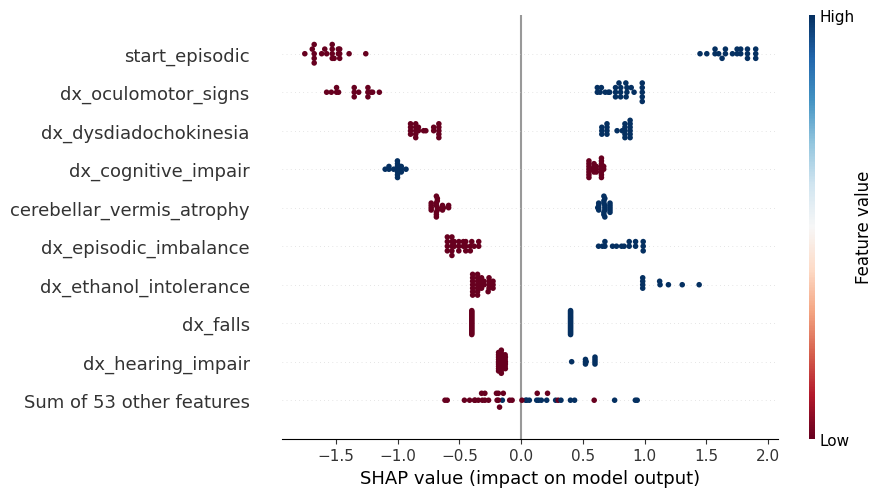

In [27]:
shap.plots.beeswarm(shap_values,  color=plt.get_cmap("RdBu"))

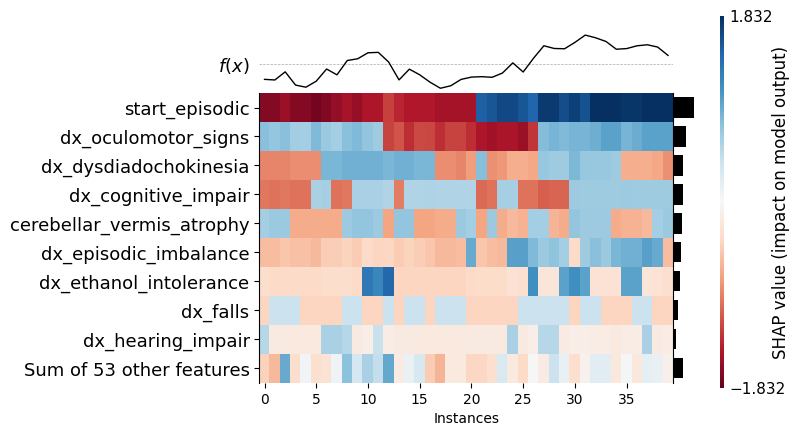

In [28]:
shap.plots.heatmap(shap_values, max_display=10, plot_width=6, cmap=plt.get_cmap("RdBu"))

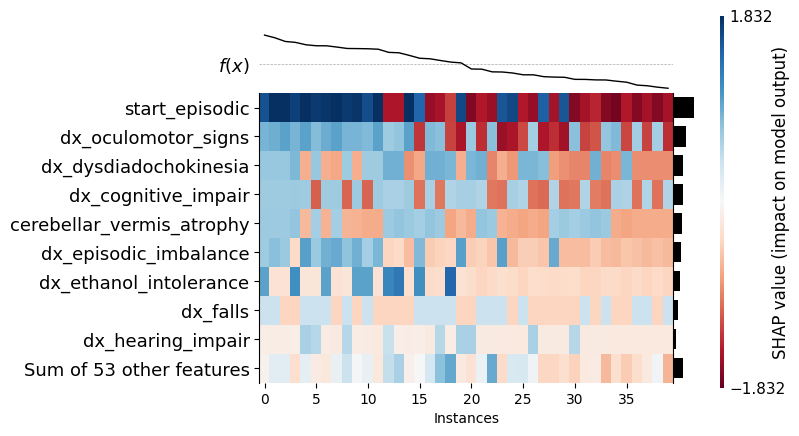

In [29]:
shap.plots.heatmap(shap_values, max_display=10, plot_width=6, instance_order=shap_values.sum(1), cmap=plt.get_cmap("RdBu"))

In [30]:
X = X.values
y = y.values

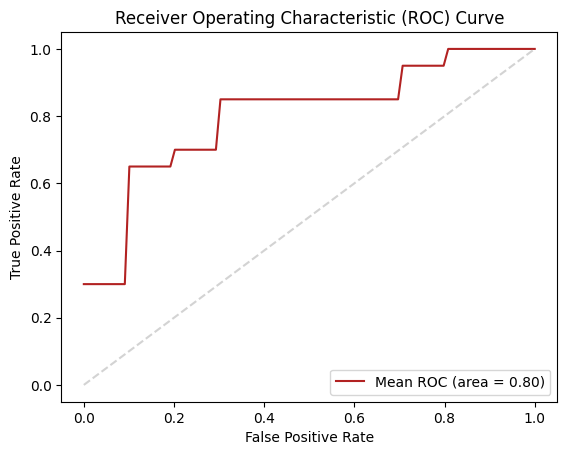

In [31]:

cv = StratifiedKFold(n_splits=2)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='firebrick', label=f'Mean ROC (area = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='lightgray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### **XGBoost FGF+ vs MSA**

In [ ]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)
df.drop(['patient_id'], axis=1, inplace=True)

In [ ]:
missing_columns_bool = df.isnull().any()

In [ ]:
filtered_df = df[ (df['genetics_conclusion'] == 'FGF') | (df['genetics_conclusion'] == 'MSA') ]
filtered_df

In [ ]:
missing_columns_bool = df.isnull().any()

In [ ]:
filtered_df.isnull().sum().sort_values(ascending=False)

In [ ]:
filtered_df = filtered_df[['genetics_conclusion']  + binary_vars ].copy()
filtered_df.isnull().sum().sort_values(ascending=False)

In [ ]:
# filtered_df.drop([ 'dx_GERD',
#         'dx_eye_disease', 'dx_rheumatological_disease',
#         'epi_diplopia', 'epi_dysarthria' , 'epi_gait_balance_impair', 
#         'epi_oscillospsia', 'epi_tremor', 'epi_vertigo' , 'epi_visual_impair', 
#         'SCA_excluded', 'FRDA_excluded', 'NGS_panel_exome', 'fragile_x', 'EA', 'RFC1',
#         'GFAP', 'C90RF72', 'HTT', 'fragile_x', 'SPG', 'ATM',
#         'perm_constipation', 'perm_diplopia', 'perm_dysarthria', 'perm_dysesthesia', 'perm_erectile_dysf', 'perm_gait_balance_impair',
#         'perm_handwriting_impair', 'perm_oscillopsia', 'perm_pseudobulbar_affect', 'perm_tremor', 'perm_urinary_dysf', 'perm_urinary_incont',
#         'perm_vertigo', 'perm_visual_impair'], axis=1, inplace=True)

In [ ]:
filtered_df['genetics_conclusion'] = filtered_df['genetics_conclusion'].apply(lambda x: 1 if x == 'FGF' else 0)

In [ ]:
y = filtered_df['genetics_conclusion']
X = filtered_df.drop(columns=['genetics_conclusion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = xgboost.XGBClassifier(n_estimators=142, max_depth=2, objective = "binary:logistic").fit(X, y)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap_values.display_data = X.values

In [ ]:
def rgba_to_hex(rgba):
    """Convert RGBA color code to hexadecimal color code."""
    r, g, b, a = rgba
    return "#{:02X}{:02X}{:02X}".format(int(r * 255), int(g * 255), int(b * 255))

cmap = plt.get_cmap('RdBu') # cmap(#) returns list with rgba
blue_hex = rgba_to_hex(cmap(0.0))
red_hex = rgba_to_hex(cmap(1.0))
print(red_hex, blue_hex)

In [ ]:
shap.initjs()
shap.force_plot(shap_values[11], plot_cmap=["#053061", "#67001F"])
# 1,2,4,5,6;9;10,11;19
# 22 24 25 29 31

In [ ]:
shap.plots.beeswarm(shap_values,  color=plt.get_cmap("RdBu"))

In [ ]:
shap.plots.heatmap(shap_values, max_display=10, plot_width=6, cmap=plt.get_cmap("RdBu"))

In [ ]:
shap.plots.heatmap(shap_values, max_display=10, plot_width=6, instance_order=shap_values.sum(1), cmap=plt.get_cmap("RdBu"))

In [ ]:
np.exp(-3)/(1+np.exp(-3))


### **Correlation between allele size and SARA score**

In [ ]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)
df = df[df['genetics_conclusion'] == 'FGF']
df = df[['patient_id', 'allele_1', 'allele_2', 'SARA']]
df['max'] = df[['allele_1', 'allele_2']].max(axis=1, skipna=True)
df = df[['patient_id', 'max',  'SARA']]

In [ ]:
df.dropna()['SARA']

In [ ]:
df.dropna()['SARA'].corr(df.dropna()['max']) # 0.01

In [ ]:
stats.pearsonr(df.dropna()['SARA'], df.dropna()['max']) # -0.4

In [ ]:
df = df.dropna(subset=['SARA', 'max'])
df['SARA'] = df['SARA'].astype(int)
df['max'] = df['max'].astype(int)

In [ ]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='max', y='SARA', data=df, edgecolor='firebrick', marker='o', linewidth=2, facecolor='none')
sns.regplot(x='max', y='SARA', data=df, scatter=False, color='firebrick')
plt.xlabel('\n Allele Length')
plt.ylabel('SARA \n')
plt.title('Scatter plot \n Allele Length vs SARA score')
plt.grid(True)
plt.grid(False)
plt.show()

### **Triad (Tetrad) Performance OLD Tetrad**

In [ ]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)
df['onset_before_45'] = df[['age_epi_sympt']].min(axis=1, skipna=True)
df['onset_before_45'] = df['onset_before_45'].apply(lambda x: 1 if x < 45 else 0)
df['onset_before_45']

In [ ]:
df = df[['genetics_conclusion', 'onset_before_45', 'dx_dysarthria', 'dx_downbeat_nystagmus', 'dx_episodic_imbalance'] ]

In [ ]:
filtered_df = df[ (df['genetics_conclusion'] == 'FGF') | (df['genetics_conclusion'] == 'Negative') ].copy()
filtered_df['genetics_conclusion'] = filtered_df['genetics_conclusion'].apply(lambda x: 1 if x == 'FGF' else 0)

In [ ]:
y = filtered_df['genetics_conclusion']
X = filtered_df.drop(columns=['genetics_conclusion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = xgboost.XGBClassifier(n_estimators=142, max_depth=2, objective = "binary:logistic").fit(X, y)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


In [ ]:
X = X.values
y = y.values

cv = StratifiedKFold(n_splits=3)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='midnightblue', label=f'Mean ROC (area = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='lightgray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### **Triad (Tetrad) Performance USING OUR TOP 4**  

In [ ]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)
df['onset_before_45'] = df[['age_epi_sympt']].min(axis=1, skipna=True)
df['onset_before_45'] = df['onset_before_45'].apply(lambda x: 1 if x < 45 else 0)


In [ ]:
df = df[['genetics_conclusion', 'start_episodic', 'dx_oculomotor_signs', 'dx_dysdiadochokinesia',  'dx_cognitive_impair', 'cerebellar_vermis_atrophy', 'dx_episodic_imbalance', 'dx_ethanol_intolerance', 'dx_falls', 'dx_hearing_impair'] ]
# df = df[['genetics_conclusion', 'start_episodic'] ]

In [ ]:
filtered_df = df[ (df['genetics_conclusion'] == 'FGF') | (df['genetics_conclusion'] == 'Negative') ].copy()
filtered_df['genetics_conclusion'] = filtered_df['genetics_conclusion'].apply(lambda x: 1 if x == 'FGF' else 0)

In [ ]:
y = filtered_df['genetics_conclusion']
X = filtered_df.drop(columns=['genetics_conclusion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = xgboost.XGBClassifier(n_estimators=142, max_depth=2, objective = "binary:logistic").fit(X, y)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


In [ ]:
X = X.values
y = y.values

cv = StratifiedKFold(n_splits=3)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='midnightblue', label=f'Mean ROC (area = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='lightgray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
X = X.values
y = y.values

cv = StratifiedKFold(n_splits=3)
tprs = []
aucs = []
mean_fpr_v2 = np.linspace(0, 1, 100)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tprs.append(np.interp(mean_fpr_v2, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

mean_tpr_v2 = np.mean(tprs, axis=0)
mean_tpr_v2[-1] = 1.0
mean_auc_v2 = auc(mean_fpr_v2, mean_tpr_v2)

#plt.plot(mean_fpr, mean_tpr, color='midnightblue', label=f'Mean ROC (area = {mean_auc:.2f})')
plt.plot(mean_fpr_v2, mean_tpr_v2, color='firebrick', label=f'Mean ROC (area = {mean_auc_v2:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='lightgray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### **Correlation between Allele Length and Age of Onset**

In [ ]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)
df = df[df['genetics_conclusion'] == 'FGF']
df['onset'] = df[['age_epi_sympt']].min(axis=1, skipna=True)
df = df[['patient_id', 'allele_1', 'allele_2', 'onset']]
df['max_allele'] = df[['allele_1', 'allele_2']].max(axis=1, skipna=True)
df = df[['patient_id', 'max_allele',  'onset']]

In [ ]:
df['max_allele'].corr(df['onset']) # -0.3552673018765272

In [ ]:
stats.pearsonr(df['max_allele'], df['onset']) # -0.4

In [ ]:
df['max_allele'] = df['max_allele'].astype(int)
df['onset'] = df['onset'].astype(int)


plt.figure(figsize=(8, 4))
sns.scatterplot(x='max_allele', y='onset', data=df, edgecolor='firebrick', marker='o', linewidth=2, facecolor='none')
sns.regplot(x='max_allele', y='onset', data=df, scatter=False, color='firebrick')
plt.xlabel('\n Allele Length')
plt.ylabel('Age at onset \n')
plt.title('Scatter plot \n Allele Length vs Age at onset')
plt.grid(True)
plt.grid(False)
plt.show()

In [ ]:
df['max_allele'] = df['max_allele'].astype(int)
df['onset'] = df['onset'].astype(int)

x_spline = df['max_allele']
splines = BSplines(x_spline, df=[4], degree=[3])
model = GLMGam(df['onset'], smoother=splines).fit()

x_pred = np.linspace(df['max_allele'].min(), df['max_allele'].max(), 100)
spline_pred = BSplines(x_pred, df=[4], degree=[3])
y_pred = model.predict(spline_pred.basis)

In [ ]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='max_allele', y='onset', data=df, alpha=0.8, edgecolor='firebrick', marker='o', linewidth=2, facecolor='none')
plt.plot(x_pred, y_pred, color='firebrick', linewidth=2)
plt.xlabel('\n Allele Length')
plt.ylabel('Age at onset \n')
plt.title('Cubic Spline Regression \n Allele Length vs Age at Onset')
plt.grid(True)
plt.grid(False)
plt.show()

### **Compare different ROC curves**

In [45]:
df = pd.read_csv('data/FGF14_pb_may_22.csv', delimiter=';', header=0)

In [47]:
df = df[['genetics_conclusion', 'dx_dysphagia', 'dx_constipation' , 'dx_urinary_problems', 'dx_oculomotor_signs', 'dx_episodic_imbalance', 'start_episodic', 'cortical_atrophy', 'brainstem_atrophy', 'dx_orthostatic_hypotension'] ]

In [48]:
filtered_df = df[ (df['genetics_conclusion'] == 'FGF') | (df['genetics_conclusion'] == 'MSA') ].copy()
filtered_df['genetics_conclusion'] = filtered_df['genetics_conclusion'].apply(lambda x: 1 if x == 'FGF' else 0)

In [49]:
y = filtered_df['genetics_conclusion']
X = filtered_df.drop(columns=['genetics_conclusion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
model = xgboost.XGBClassifier(n_estimators=142, max_depth=2, objective = "binary:logistic").fit(X, y)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=142, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [51]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


In [37]:
X = X.values
y = y.values

cv = StratifiedKFold(n_splits=3)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

In [44]:
X = X.values
y = y.values

cv = StratifiedKFold(n_splits=3)
tprs = []
aucs = []
mean_fpr_v2 = np.linspace(0, 1, 100)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tprs.append(np.interp(mean_fpr_v2, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

mean_tpr_v2 = np.mean(tprs, axis=0)
mean_tpr_v2[-1] = 1.0
mean_auc_v2 = auc(mean_fpr_v2, mean_tpr_v2)

In [52]:
X = X.values
y = y.values

cv = StratifiedKFold(n_splits=3)
tprs = []
aucs = []
mean_fpr_v3 = np.linspace(0, 1, 100)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tprs.append(np.interp(mean_fpr_v3, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

mean_tpr_v3 = np.mean(tprs, axis=0)
mean_tpr_v3[-1] = 1.0
mean_auc_v3 = auc(mean_fpr_v3, mean_tpr_v3)

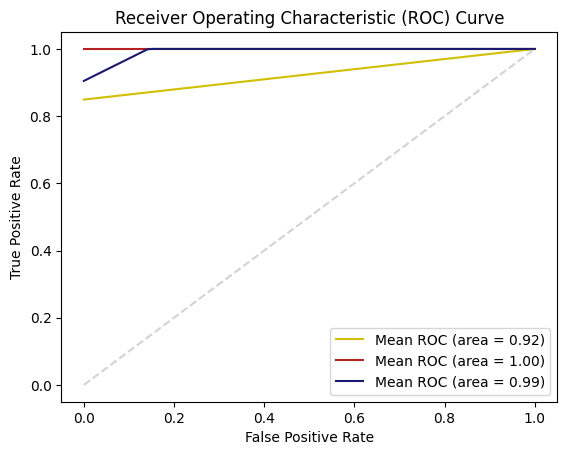

In [53]:

plt.plot(mean_fpr, mean_tpr, color='#D1BF02', label=f'Mean ROC (area = {mean_auc:.2f})')
plt.plot(mean_fpr_v2, mean_tpr_v2, color='firebrick', label=f'Mean ROC (area = {mean_auc_v2:.2f})')
plt.plot(mean_fpr_v3, mean_tpr_v3, color='midnightblue', label=f'Mean ROC (area = {mean_auc_v3:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='lightgray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()